In [19]:
import pandas as pd
import numpy as np
import time
import datetime 
from dateutil.parser import parse
from datetime import date, timedelta
from pandas.tseries.offsets import *

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import *
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
import pickle
from lunar import *

%matplotlib inline

## data 集初步整理

In [20]:
s = Solar(2014,1,1)
cvt = LunarSolarConverter()
l = cvt.SolarToLunar(s)
print(l.lunarYear, l.lunarMonth, l.lunarDay)

2013 12 1


In [21]:
df_origin = pd.read_table('train_20171215.txt',encoding='gbk',sep='\t')

In [22]:
df=pd.DataFrame(df_origin[['date','cnt','day_of_week']].groupby(['date','day_of_week']).cnt.agg('sum').reset_index())

In [23]:
df['gap']=0

In [24]:
for idx, row in df.iterrows():
    if idx==0:
        row['gap']=1
        continue
    row['gap']=row['day_of_week']-df.iloc[idx-1,:]['day_of_week']
    while row['gap']<=0:
        row['gap']+=7

In [25]:
df['virtual_date']=pd.NaT

In [26]:
for idx, row in df.iterrows():
    if idx==0:
        d=datetime.date(2014,1,1)
        while d.weekday()!=df.loc[idx,'day_of_week']-1:
            d += DateOffset(days=1)
        df.loc[idx, 'virtual_date']=d
        continue
    df.loc[idx, 'virtual_date']=df.loc[idx-1,'virtual_date']+DateOffset(days=row['gap'])


In [27]:
# get all the holidays
holidays={'date':[],
          'length':[]}
for idx, row in df.iterrows():
    if row['gap']>2:
        holidays['length'].append(row['gap'])
        holidays['date'].append(row['virtual_date']+DateOffset(days=-(row['gap']//2)))
# convert to DataFrame
holidays_df = pd.DataFrame(holidays, columns=['date','length'])

# get holiday features
df['h_distance'] = 100
df['h_length'] = 0
df['h_month'] = 0
df['h_type']=np.nan
for idx, row in df.iterrows():
    delta = holidays_df['date']-row['virtual_date']
    nearest_idx = delta.abs().values.argmin()
    df.loc[idx, 'h_distance'] = delta[nearest_idx].days
    df.loc[idx, 'h_length'] = holidays_df.loc[nearest_idx, 'length']
    df.loc[idx, 'h_month'] = holidays_df.loc[nearest_idx, 'date'].month
    if df.loc[idx, 'h_month'] in [1,2]:
        df.loc[idx, 'h_type'] = 1
    elif df.loc[idx, 'h_month'] in [9,10]:
        df.loc[idx, 'h_type'] = 2
    else:
        df.loc[idx, 'h_type'] = 0

In [28]:
df['month']=df['virtual_date'].dt.month
df['year']=df['virtual_date'].dt.year
df['week']=df['virtual_date'].dt.week
df['day']=df['virtual_date'].dt.day
# df['doy']=df['virtual_date'].dt.dayofyear
df['xun'] = df['day'].apply(lambda x: x//7)

In [29]:
df['lunar_month']=df['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarMonth)
df['lunar_day']=df['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarDay)
df['lunar_year']=df['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarYear)

In [30]:
df2 = df.drop('cnt', axis=1)

In [31]:
df = df_origin.merge(df2, on=['date','day_of_week'])

In [32]:
solar_cols = ['cnt','month','year','brand']
lunar_cols = ['cnt','lunar_month','lunar_year','brand']
solar_history = pd.DataFrame(df[solar_cols].groupby(['brand','month','year']).cnt.agg('sum'))
solar_history_count = pd.DataFrame(df[solar_cols].groupby(['brand','month','year']).count())

lunar_history = pd.DataFrame(df[lunar_cols].groupby(['brand','lunar_month', 'lunar_year']).cnt.agg('sum'))
lunar_history_count = pd.DataFrame(df[lunar_cols].groupby(['brand','lunar_month', 'lunar_year']).count())

In [33]:
df['last_solar_year_avg']=np.nan
df['last_lunar_year_avg']=np.nan
for idx, row in df.iterrows():
    b = row['brand']
    year, month = row['year']-1, row['month']
    l_year, l_month = row['lunar_year']-1, row['lunar_month']
    s = solar_history.loc[b]
    s_count = solar_history_count.loc[b]
    l = lunar_history.loc[b]
    l_count = lunar_history_count.loc[b]
    if year in s.loc[month].index:
        df.loc[idx, 'last_solar_year_avg']= (s.loc[month].loc[year]/s_count.loc[month].loc[year])[0]
    if l_year in l.loc[l_month].index:
        df.loc[idx, 'last_lunar_year_avg']= (l.loc[l_month].loc[l_year]/l_count.loc[l_month].loc[l_year])[0]    

In [34]:
df = df.drop(['date'], axis=1)

In [35]:
df.tail()

,day_of_week,brand,cnt,gap,virtual_date,h_distance,h_length,h_month,h_type,month,year,week,day,xun,lunar_month,lunar_day,lunar_year,last_solar_year_avg,last_lunar_year_avg
4768,3,5,288,1,2017-04-05,-2,3,4,0.0,4,2017,14,5,0,3,9,2017,380.000000,418.916667
4769,4,1,436,1,2017-04-06,-3,3,4,0.0,4,2017,14,6,0,3,10,2017,408.217391,392.280000
4770,4,2,393,1,2017-04-06,-3,3,4,0.0,4,2017,14,6,0,3,10,2017,336.083333,348.280000
4771,4,3,235,1,2017-04-06,-3,3,4,0.0,4,2017,14,6,0,3,10,2017,325.761905,339.173913
4772,4,4,242,1,2017-04-06,-3,3,4,0.0,4,2017,14,6,0,3,10,2017,316.272727,328.000000


In [36]:
df.shape

(4773, 19)

## 建立 function

In [37]:
def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result

In [38]:
def left_merge(data1,data2,on):
    if type(on) != list:
        on = [on]
    if (set(on) & set(data2.columns)) != set(on):  
        data2_temp = data2.reset_index()
    else:
        data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp,on=on,how='left')
    result = result[columns]                      
    return result

In [39]:
def diff_of_days(day1, day2):
    days = (parse(day1) - parse(day2)).days 
    return days               #.days 两个date之间相差了几天（int）

In [40]:
def date_add_days(start_date, days):
    end_date =  parse(start_date) + timedelta(days = days)
    end_date = end_date.strftime('%Y-%m-%d')
    return end_date                                     #取得最终日期

In [41]:
def get_label(end_date,n_day):
    start_date = date_add_days(end_date, -n_day)  #其实是 start date
    label = df[(df['virtual_date'] < end_date) & (df['virtual_date'] >= start_date)].copy()  #复制在EndDate和LabelEndDate之间的data
    label['start_date'] = start_date
    label['diff_of_day'] = label['virtual_date'].apply(lambda x: diff_of_days(str(x),str(start_date)))
    label['month'] = label['virtual_date'].dt.month.astype(int) 
    label['year'] = label['virtual_date'].dt.year.astype(int)
#     for i in [3,2,1,-1]:
#         date_info_temp = df.copy()
#         date_info_temp['virtual_date'] = date_info_temp['virtual_date'].apply(lambda x: date_add_days(str(x),i)) #加上几天，计算出节前和节后日
#         label = label.merge(date_info_temp, on=['virtual_date'],how='left') #取得EndDate和LabelEndDate之间的data和 merge 上的节前和节后日
    label = label.reset_index(drop=True)
    return label

In [42]:
def quantity_feature(label, end_date, n_day):
    # end_date 往前 n_day 的统计信息
    start_date = date_add_days(end_date, -n_day)    #key[0]是 end date
    data_temp = df[(df['virtual_date'] >= start_date) & (df['virtual_date'] < end_date)]
    result = data_temp.groupby(['day_of_week']).cnt.agg({'mean{}'.format(n_day):'mean',
                                                                'median{}'.format(n_day): 'median',
                                                                'min{}'.format(n_day): 'min',
                                                                'max{}'.format(n_day): 'max',
                                                                'std{}'.format(n_day): 'std',
                                                                'count{}'.format(n_day): 'count',
                                                                'skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['day_of_week']).fillna(0)
    return result

In [43]:
#end_date, n_day = date_add_days(start_date, 0), 30
#key = date_add_days(start_date, 0),n_day
#start_date = date_add_days(key[0], -n_day)
#data_temp = df[(df['virtual_date'] >= start_date) & (df['virtual_date'] < key[0])]

In [44]:
#data_temp.head()

In [45]:
def diff_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = df[(df['virtual_date'] >= start_date) & (df['virtual_date'] < key[0])].copy()
    result = data_temp.set_index(['virtual_date','day_of_week'])['cnt'].unstack()
    result = result.diff(axis=1).iloc[:,1:]  
    c = result.columns
    result['diff_mean'] = np.abs(result[c]).mean(axis=1)
    result['diff_std'] = result[c].std(axis=1)
    result['diff_max'] = result[c].max(axis=1)
    result['sdiff_min'] = result[c].min(axis=1)
    result = left_merge(label, result[['diff_mean', 'diff_std', 'diff_max', 'diff_min']],on=['virtual_date','day_of_week']).fillna(0)
    return result

In [46]:
def ratio_feature(data):
    data['mean7_14'] = data['mean7']/(data['mean14']+0.01)
    data['mean14_30'] = data['mean14']/(data['mean30']+0.01)
    data['mean30_60'] = data['mean30']/(data['mean60']+0.01)
    data['mean60_90'] = data['mean60']/(data['mean90']+0.01)
    data['mean90_120'] = data['mean90']/(data['mean120']+0.01)
    data['mean120_150'] = data['mean120']/(data['mean150']+0.01)
    data['mean150_180'] = data['mean150']/(data['mean180']+0.01)
    data['mean180_360'] = data['mean180']/(data['mean360']+0.01)
#    data['mean360_720'] = data['mean180']/(data['mean360']+0.01)
    return data

In [47]:
def make_feats(end_date,n_day):
    t0 = time.time()
    key = end_date,n_day
    
    print('add label...')
    
    label = get_label(end_date, n_day) # enddate = 0215 nday = 315   # enddate = 0307 nday = 120
    
    # label是end_date为最后一天（不包括），往前n_day
    
    start_date = date_add_days(end_date, -n_day) # startdate = 0407 #startdate = 0107 (enddate 往前120天）
    
    print('make feature...')
    result = [label]
    result.append(quantity_feature(label, start_date, 7)) 
    result.append(quantity_feature(label, start_date, 14))
    result.append(quantity_feature(label, start_date, 30))
    result.append(quantity_feature(label, start_date, 60))
    result.append(quantity_feature(label, start_date, 90))
    result.append(quantity_feature(label, start_date, 120))
    result.append(quantity_feature(label, start_date, 150))
    result.append(quantity_feature(label, start_date, 180))
    result.append(quantity_feature(label, start_date, 360))

    
    result.append(label)

    print('merge...')
    result = concat(result)

    result = ratio_feature(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result

## 制作 data

In [48]:
train_feat = pd.DataFrame()
start_date = str((df['virtual_date'].max()+DateOffset(days=-345)).date())#'2016-10-03'
print(df['virtual_date'].max())
print(start_date)

2017-04-06 00:00:00
2016-04-26


In [49]:
for i in range(101):
    if date_add_days(start_date, i*(-61)) < date_add_days('2014-01-01',120):
        break
    train_feat_sub = make_feats(date_add_days(start_date, i*(-61)), 120)
    train_feat = pd.concat([train_feat,train_feat_sub])

add label...
make feature...
merge...
data shape：(476, 92)

/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()



spending 0.271773099899292s
add label...
make feature...
merge...
data shape：(478, 92)
spending 0.2478621006011963s
add label...
make feature...
merge...
data shape：(486, 92)
spending 0.23775196075439453s
add label...
make feature...
merge...
data shape：(477, 92)
spending 0.2566030025482178s
add label...
make feature...
merge...
data shape：(487, 92)
spending 0.2274036407470703s
add label...
make feature...
merge...
data shape：(492, 92)
spending 0.259552001953125s
add label...
make feature...
merge...
data shape：(479, 92)
spending 0.22328996658325195s
add label...
make feature...
merge...
data shape：(481, 92)
spending 0.25226402282714844s
add label...
make feature...
merge...
data shape：(480, 92)
spending 0.22450470924377441s
add label...
make feature...
merge...
data shape：(471, 92)
spending 0.21313881874084473s
add label...
make feature...
merge...
data shape：(473, 92)
spending 0.27013707160949707s
add label...
make feature...
merge...
data shape：(484, 92)
spending 0.2860269546508789

In [50]:
train_feat.tail()
print(train_feat['virtual_date'].min())
print(train_feat['virtual_date'].max())

2014-02-25 00:00:00
2016-04-25 00:00:00


In [51]:
train_feat.shape

(5764, 92)

In [52]:
train_feat.tail()

,day_of_week,brand,cnt,gap,virtual_date,h_distance,h_length,h_month,h_type,month,...,count360,skew360,mean7_14,mean14_30,mean30_60,mean60_90,mean90_120,mean120_150,mean150_180,mean180_360
479,2,1,653,1,2014-06-24,-13,3,6,0.0,6,...,30,0.673841,0.999971,0.592162,0.976877,0.999983,0.999983,0.999983,0.999983,0.999983
480,2,2,412,1,2014-06-24,-13,3,6,0.0,6,...,30,0.673841,0.999971,0.592162,0.976877,0.999983,0.999983,0.999983,0.999983,0.999983
481,2,3,347,1,2014-06-24,-13,3,6,0.0,6,...,30,0.673841,0.999971,0.592162,0.976877,0.999983,0.999983,0.999983,0.999983,0.999983
482,2,4,332,1,2014-06-24,-13,3,6,0.0,6,...,30,0.673841,0.999971,0.592162,0.976877,0.999983,0.999983,0.999983,0.999983,0.999983
483,2,5,592,1,2014-06-24,-13,3,6,0.0,6,...,30,0.673841,0.999971,0.592162,0.976877,0.999983,0.999983,0.999983,0.999983,0.999983


In [53]:
for i in range(1,6):
    train_feat_sub = make_feats(date_add_days(start_date, min(i*(7),31)),40 - (i*7))
    train_feat = pd.concat([train_feat,train_feat_sub])

add label...
make feature...
merge...
data shape：(123, 92)
spending 0.24741792678833008s


/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


add label...
make feature...
merge...
data shape：(101, 92)
spending 0.17353391647338867s
add label...
make feature...
merge...
data shape：(71, 92)
spending 0.16434884071350098s
add label...
make feature...
merge...
data shape：(50, 92)
spending 0.1663069725036621s
add label...
make feature...
merge...
data shape：(20, 92)
spending 0.15693116188049316s


In [54]:
train_feat.tail()
print(train_feat['virtual_date'].min())
print(train_feat['virtual_date'].max())

2014-02-25 00:00:00
2016-05-26 00:00:00


In [55]:
test_feat = make_feats(str(df['virtual_date'].max()+DateOffset(days=1)),315)

add label...
make feature...
merge...
data shape：(1261, 92)
spending 0.3840823173522949s


/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


In [56]:
print(test_feat['virtual_date'].min())
print(test_feat['virtual_date'].max())

2016-05-27 00:00:00
2017-04-06 00:00:00


## train

In [57]:
train_df = train_feat.drop(['virtual_date','start_date'], axis=1)
validation_df = test_feat.drop(['virtual_date','start_date'], axis=1)
train_X = train_df.drop(['cnt','year','lunar_year'], axis=1)
train_Y = train_df['cnt']
test_X = validation_df.drop(['cnt','year','lunar_year'], axis=1)
test_Y = validation_df['cnt'] 

In [58]:
train_X.head()

,day_of_week,brand,gap,h_distance,h_length,h_month,h_type,month,week,day,...,count360,skew360,mean7_14,mean14_30,mean30_60,mean60_90,mean90_120,mean120_150,mean150_180,mean180_360
0,1,1,1,5,3,1,1.0,12,53,28,...,234,1.632484,0.859664,0.923706,0.988214,0.998619,0.942371,1.020425,1.018754,0.963777
1,1,2,1,5,3,1,1.0,12,53,28,...,234,1.632484,0.859664,0.923706,0.988214,0.998619,0.942371,1.020425,1.018754,0.963777
2,1,3,1,5,3,1,1.0,12,53,28,...,234,1.632484,0.859664,0.923706,0.988214,0.998619,0.942371,1.020425,1.018754,0.963777
3,1,4,1,5,3,1,1.0,12,53,28,...,234,1.632484,0.859664,0.923706,0.988214,0.998619,0.942371,1.020425,1.018754,0.963777
4,1,5,1,5,3,1,1.0,12,53,28,...,234,1.632484,0.859664,0.923706,0.988214,0.998619,0.942371,1.020425,1.018754,0.963777


In [59]:
train_Y.head()

0    507
1    307
2    560
3    234
4    559
Name: cnt, dtype: int64

In [60]:
train_X[['last_solar_year_avg','last_lunar_year_avg']] = train_X[['last_solar_year_avg','last_lunar_year_avg']].fillna(train_X[['last_solar_year_avg','last_lunar_year_avg']].median())

In [61]:
#knn_cols = ['day_of_week', 'h_distance', 'h_length', 'h_month', 'month','lunar_month',
#             'last_solar_year_avg', 'last_lunar_year_avg']

In [68]:
predict = 0
bagging_num = 1
for i in range(bagging_num):
#     model1 = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=2000, max_depth=10, max_features=0.8,
#                                            min_samples_split = 5, random_state = i*3)
#     model1.fit(train_X.fillna(-1), train_Y)
#     predict +=  0.4*model1.predict(test_X.fillna(-1))
    
    model1 = LGBMRegressor(boosting_type='gbdt',learning_rate=0.011, n_estimators=1500, subsample=0.7, num_leaves=60+i*5, 
                           colsample_bytree=0.5, random_seed = i*3)
    model1.fit(train_X.fillna(-1), train_Y, categorical_feature=['brand'])
    predict +=  model1.predict(test_X.fillna(-1))

    model1 = CatBoostRegressor(iterations=1500, learning_rate=0.04, depth=6, l2_leaf_reg=2, loss_function='RMSE', 
                           eval_metric='RMSE', random_seed=i*5)
    model1.fit(train_X.fillna(-1), train_Y,cat_features=[1,6,7,8])
    predict += 1.5*model1.predict(test_X.fillna(-1))

#     model1 = KNeighborsRegressor(n_jobs=-1, n_neighbors=20)
#     model1 = LinearRegression(n_jobs=-1)
#     model1.fit(train_X.fillna(-1), train_Y)
#     predict += 0.2*model1.predict(test_X.fillna(-1))
predict = predict/bagging_num/2.5


/Users/olivia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['brand']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0:	learn: 417.3219396	total: 52.8ms	remaining: 1m 19s
1:	learn: 404.6689980	total: 82.1ms	remaining: 1m 1s
2:	learn: 392.4767593	total: 123ms	remaining: 1m 1s
3:	learn: 380.7894348	total: 165ms	remaining: 1m 1s
4:	learn: 369.7079835	total: 192ms	remaining: 57.4s
5:	learn: 359.1792557	total: 229ms	remaining: 57s
6:	learn: 349.3465698	total: 273ms	remaining: 58.2s
7:	learn: 339.6707016	total: 327ms	remaining: 1m 1s
8:	learn: 330.2096019	total: 363ms	remaining: 1m
9:	learn: 321.8788760	total: 393ms	remaining: 58.5s
10:	learn: 313.8517051	total: 415ms	remaining: 56.2s
11:	learn: 306.4931069	total: 437ms	remaining: 54.1s
12:	learn: 298.7665298	total: 539ms	remaining: 1m 1s
13:	learn: 291.0378483	total: 645ms	remaining: 1m 8s
14:	learn: 284.5427682	total: 728ms	remaining: 1m 12s
15:	learn: 277.7728364	total: 825ms	remaining: 1m 16s
16:	learn: 271.4520663	total: 873ms	remaining: 1m 16s
17:	learn: 265.2222051	total: 921ms	remaining: 1m 15s
18:	learn: 259.5619977	total: 956ms	remaining: 1m 14s


155:	learn: 139.4876520	total: 7.1s	remaining: 1m 1s
156:	learn: 139.3379238	total: 7.13s	remaining: 1m 1s
157:	learn: 139.2833275	total: 7.17s	remaining: 1m
158:	learn: 139.1555249	total: 7.25s	remaining: 1m 1s
159:	learn: 139.0608358	total: 7.32s	remaining: 1m 1s
160:	learn: 138.8931643	total: 7.35s	remaining: 1m 1s
161:	learn: 138.8262216	total: 7.37s	remaining: 1m
162:	learn: 138.6259793	total: 7.4s	remaining: 1m
163:	learn: 138.6242079	total: 7.4s	remaining: 1m
164:	learn: 138.3341580	total: 7.44s	remaining: 1m
165:	learn: 138.2322360	total: 7.46s	remaining: 60s
166:	learn: 138.2307378	total: 7.47s	remaining: 59.6s
167:	learn: 138.2080864	total: 7.48s	remaining: 59.3s
168:	learn: 138.1260103	total: 7.5s	remaining: 59.1s
169:	learn: 137.9119637	total: 7.54s	remaining: 59s
170:	learn: 137.8065668	total: 7.57s	remaining: 58.9s
171:	learn: 137.7080126	total: 7.6s	remaining: 58.7s
172:	learn: 137.6676085	total: 7.68s	remaining: 58.9s
173:	learn: 137.5347115	total: 7.78s	remaining: 59.3

310:	learn: 125.6313644	total: 13.2s	remaining: 50.6s
311:	learn: 125.5638793	total: 13.3s	remaining: 50.6s
312:	learn: 125.4999740	total: 13.4s	remaining: 50.7s
313:	learn: 125.4256646	total: 13.4s	remaining: 50.7s
314:	learn: 125.3383779	total: 13.5s	remaining: 50.7s
315:	learn: 125.2999526	total: 13.5s	remaining: 50.7s
316:	learn: 125.2358792	total: 13.6s	remaining: 50.6s
317:	learn: 125.1470058	total: 13.6s	remaining: 50.6s
318:	learn: 125.0642867	total: 13.6s	remaining: 50.5s
319:	learn: 125.0042369	total: 13.7s	remaining: 50.4s
320:	learn: 124.9137983	total: 13.7s	remaining: 50.3s
321:	learn: 124.8854620	total: 13.7s	remaining: 50.2s
322:	learn: 124.8459029	total: 13.7s	remaining: 50.1s
323:	learn: 124.7744565	total: 13.8s	remaining: 50s
324:	learn: 124.6689663	total: 13.8s	remaining: 49.9s
325:	learn: 124.6201490	total: 13.8s	remaining: 49.9s
326:	learn: 124.5895890	total: 14s	remaining: 50.3s
327:	learn: 124.5596210	total: 14.1s	remaining: 50.2s
328:	learn: 124.5048431	total: 1

467:	learn: 117.4945276	total: 19.2s	remaining: 42.3s
468:	learn: 117.3042888	total: 19.2s	remaining: 42.3s
469:	learn: 117.2373199	total: 19.3s	remaining: 42.2s
470:	learn: 117.0291227	total: 19.3s	remaining: 42.1s
471:	learn: 116.9214031	total: 19.3s	remaining: 42.1s
472:	learn: 116.8895326	total: 19.3s	remaining: 42s
473:	learn: 116.8709428	total: 19.4s	remaining: 41.9s
474:	learn: 116.8384458	total: 19.4s	remaining: 41.9s
475:	learn: 116.8355025	total: 19.4s	remaining: 41.8s
476:	learn: 116.7762136	total: 19.5s	remaining: 41.8s
477:	learn: 116.7229357	total: 19.5s	remaining: 41.7s
478:	learn: 116.7044252	total: 19.5s	remaining: 41.6s
479:	learn: 116.6977811	total: 19.6s	remaining: 41.6s
480:	learn: 116.6879080	total: 19.6s	remaining: 41.5s
481:	learn: 116.6855122	total: 19.6s	remaining: 41.4s
482:	learn: 116.6619794	total: 19.6s	remaining: 41.4s
483:	learn: 116.5225555	total: 19.7s	remaining: 41.3s
484:	learn: 116.4459068	total: 19.7s	remaining: 41.2s
485:	learn: 116.4441078	total:

623:	learn: 111.1134472	total: 24.9s	remaining: 35s
624:	learn: 111.0820391	total: 24.9s	remaining: 34.9s
625:	learn: 111.0597053	total: 25s	remaining: 34.8s
626:	learn: 111.0331688	total: 25s	remaining: 34.8s
627:	learn: 110.9759480	total: 25s	remaining: 34.7s
628:	learn: 110.9433978	total: 25s	remaining: 34.7s
629:	learn: 110.8575060	total: 25.1s	remaining: 34.7s
630:	learn: 110.8083608	total: 25.2s	remaining: 34.7s
631:	learn: 110.8023436	total: 25.2s	remaining: 34.6s
632:	learn: 110.7634990	total: 25.2s	remaining: 34.6s
633:	learn: 110.7516747	total: 25.3s	remaining: 34.5s
634:	learn: 110.7510676	total: 25.3s	remaining: 34.5s
635:	learn: 110.7285257	total: 25.3s	remaining: 34.4s
636:	learn: 110.7184897	total: 25.4s	remaining: 34.3s
637:	learn: 110.7006896	total: 25.4s	remaining: 34.3s
638:	learn: 110.6902716	total: 25.4s	remaining: 34.2s
639:	learn: 110.6560983	total: 25.4s	remaining: 34.2s
640:	learn: 110.6389399	total: 25.5s	remaining: 34.1s
641:	learn: 110.6355699	total: 25.5s	r

777:	learn: 107.2187240	total: 30.4s	remaining: 28.2s
778:	learn: 107.2034168	total: 30.5s	remaining: 28.2s
779:	learn: 107.1957112	total: 30.5s	remaining: 28.1s
780:	learn: 107.1808641	total: 30.5s	remaining: 28.1s
781:	learn: 107.1568732	total: 30.6s	remaining: 28.1s
782:	learn: 107.0906217	total: 30.6s	remaining: 28s
783:	learn: 107.0851411	total: 30.6s	remaining: 27.9s
784:	learn: 107.0627258	total: 30.6s	remaining: 27.9s
785:	learn: 107.0443016	total: 30.7s	remaining: 27.9s
786:	learn: 106.9953409	total: 30.7s	remaining: 27.8s
787:	learn: 106.9871487	total: 30.7s	remaining: 27.8s
788:	learn: 106.9751589	total: 30.8s	remaining: 27.7s
789:	learn: 106.9632126	total: 30.8s	remaining: 27.7s
790:	learn: 106.9392988	total: 30.8s	remaining: 27.6s
791:	learn: 106.9358466	total: 30.9s	remaining: 27.6s
792:	learn: 106.9002121	total: 30.9s	remaining: 27.6s
793:	learn: 106.8990580	total: 30.9s	remaining: 27.5s
794:	learn: 106.8731385	total: 31s	remaining: 27.5s
795:	learn: 106.8706032	total: 3

933:	learn: 103.6775810	total: 36s	remaining: 21.8s
934:	learn: 103.6392401	total: 36s	remaining: 21.8s
935:	learn: 103.6318381	total: 36s	remaining: 21.7s
936:	learn: 103.6191674	total: 36.1s	remaining: 21.7s
937:	learn: 103.6164750	total: 36.2s	remaining: 21.7s
938:	learn: 103.6162757	total: 36.2s	remaining: 21.6s
939:	learn: 103.5846815	total: 36.3s	remaining: 21.6s
940:	learn: 103.5736568	total: 36.3s	remaining: 21.6s
941:	learn: 103.5264984	total: 36.3s	remaining: 21.5s
942:	learn: 103.5198161	total: 36.4s	remaining: 21.5s
943:	learn: 103.5189411	total: 36.4s	remaining: 21.4s
944:	learn: 103.4797460	total: 36.5s	remaining: 21.4s
945:	learn: 103.4652616	total: 36.5s	remaining: 21.4s
946:	learn: 103.4410128	total: 36.5s	remaining: 21.3s
947:	learn: 103.4328552	total: 36.6s	remaining: 21.3s
948:	learn: 103.4181914	total: 36.6s	remaining: 21.2s
949:	learn: 103.3920658	total: 36.6s	remaining: 21.2s
950:	learn: 103.3789404	total: 36.6s	remaining: 21.2s
951:	learn: 103.3743202	total: 36.

1089:	learn: 100.9999861	total: 42s	remaining: 15.8s
1090:	learn: 100.9909417	total: 42s	remaining: 15.7s
1091:	learn: 100.9735468	total: 42s	remaining: 15.7s
1092:	learn: 100.9116245	total: 42s	remaining: 15.7s
1093:	learn: 100.9046923	total: 42.1s	remaining: 15.6s
1094:	learn: 100.9025754	total: 42.1s	remaining: 15.6s
1095:	learn: 100.8743739	total: 42.1s	remaining: 15.5s
1096:	learn: 100.8677988	total: 42.2s	remaining: 15.5s
1097:	learn: 100.8621185	total: 42.2s	remaining: 15.5s
1098:	learn: 100.8514162	total: 42.3s	remaining: 15.4s
1099:	learn: 100.8417788	total: 42.3s	remaining: 15.4s
1100:	learn: 100.8179324	total: 42.3s	remaining: 15.3s
1101:	learn: 100.8066675	total: 42.4s	remaining: 15.3s
1102:	learn: 100.7810392	total: 42.4s	remaining: 15.3s
1103:	learn: 100.7807118	total: 42.5s	remaining: 15.2s
1104:	learn: 100.7795427	total: 42.5s	remaining: 15.2s
1105:	learn: 100.7569317	total: 42.5s	remaining: 15.2s
1106:	learn: 100.7366350	total: 42.6s	remaining: 15.1s
1107:	learn: 100.7

1247:	learn: 98.5451111	total: 47.8s	remaining: 9.65s
1248:	learn: 98.5285408	total: 47.8s	remaining: 9.61s
1249:	learn: 98.4996221	total: 47.9s	remaining: 9.57s
1250:	learn: 98.4807007	total: 47.9s	remaining: 9.53s
1251:	learn: 98.4701971	total: 47.9s	remaining: 9.49s
1252:	learn: 98.4580528	total: 47.9s	remaining: 9.45s
1253:	learn: 98.4574486	total: 48s	remaining: 9.41s
1254:	learn: 98.4476973	total: 48s	remaining: 9.37s
1255:	learn: 98.4251872	total: 48s	remaining: 9.33s
1256:	learn: 98.4105321	total: 48s	remaining: 9.29s
1257:	learn: 98.4046919	total: 48.1s	remaining: 9.25s
1258:	learn: 98.3885415	total: 48.1s	remaining: 9.21s
1259:	learn: 98.3825225	total: 48.1s	remaining: 9.17s
1260:	learn: 98.3780561	total: 48.1s	remaining: 9.13s
1261:	learn: 98.3483182	total: 48.2s	remaining: 9.09s
1262:	learn: 98.3256767	total: 48.2s	remaining: 9.05s
1263:	learn: 98.3186532	total: 48.2s	remaining: 9.01s
1264:	learn: 98.3147985	total: 48.3s	remaining: 8.97s
1265:	learn: 98.3121881	total: 48.3s

1402:	learn: 96.2920478	total: 54.2s	remaining: 3.75s
1403:	learn: 96.2644973	total: 54.3s	remaining: 3.71s
1404:	learn: 96.2546004	total: 54.3s	remaining: 3.67s
1405:	learn: 96.2396221	total: 54.4s	remaining: 3.63s
1406:	learn: 96.2194871	total: 54.4s	remaining: 3.6s
1407:	learn: 96.2166212	total: 54.4s	remaining: 3.56s
1408:	learn: 96.2037174	total: 54.5s	remaining: 3.52s
1409:	learn: 96.1768376	total: 54.5s	remaining: 3.48s
1410:	learn: 96.1701379	total: 54.5s	remaining: 3.44s
1411:	learn: 96.1592021	total: 54.5s	remaining: 3.4s
1412:	learn: 96.1541301	total: 54.6s	remaining: 3.36s
1413:	learn: 96.1302796	total: 54.6s	remaining: 3.32s
1414:	learn: 96.1006563	total: 54.6s	remaining: 3.28s
1415:	learn: 96.0898363	total: 54.7s	remaining: 3.24s
1416:	learn: 96.0832203	total: 54.7s	remaining: 3.21s
1417:	learn: 96.0804338	total: 54.8s	remaining: 3.17s
1418:	learn: 96.0502867	total: 54.8s	remaining: 3.13s
1419:	learn: 96.0321677	total: 54.9s	remaining: 3.09s
1420:	learn: 96.0248522	total:

In [63]:
predict_df = pd.DataFrame()
predict_df['date'] = test_feat['virtual_date']
predict_df['y'] = predict
predict_sum = predict_df.groupby(['date']).y.agg('sum')

In [64]:
#predict_sum = predict_sum*1.5/2.5

In [65]:
testy_df = pd.DataFrame()
testy_df['date'] = test_feat['virtual_date']
testy_df['y'] = test_Y
testy_sum = testy_df.groupby(['date']).y.agg('sum')

In [66]:
error = predict_sum.values - testy_sum.values
metric= np.mean(np.square(error))
print(metric)

314296.94216703356


In [ ]:
# original 267671

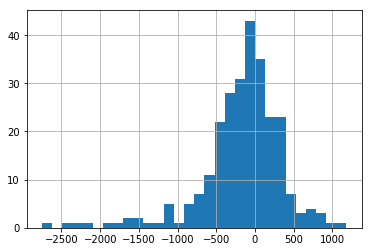

In [67]:
pd.Series(error).hist(bins=30)

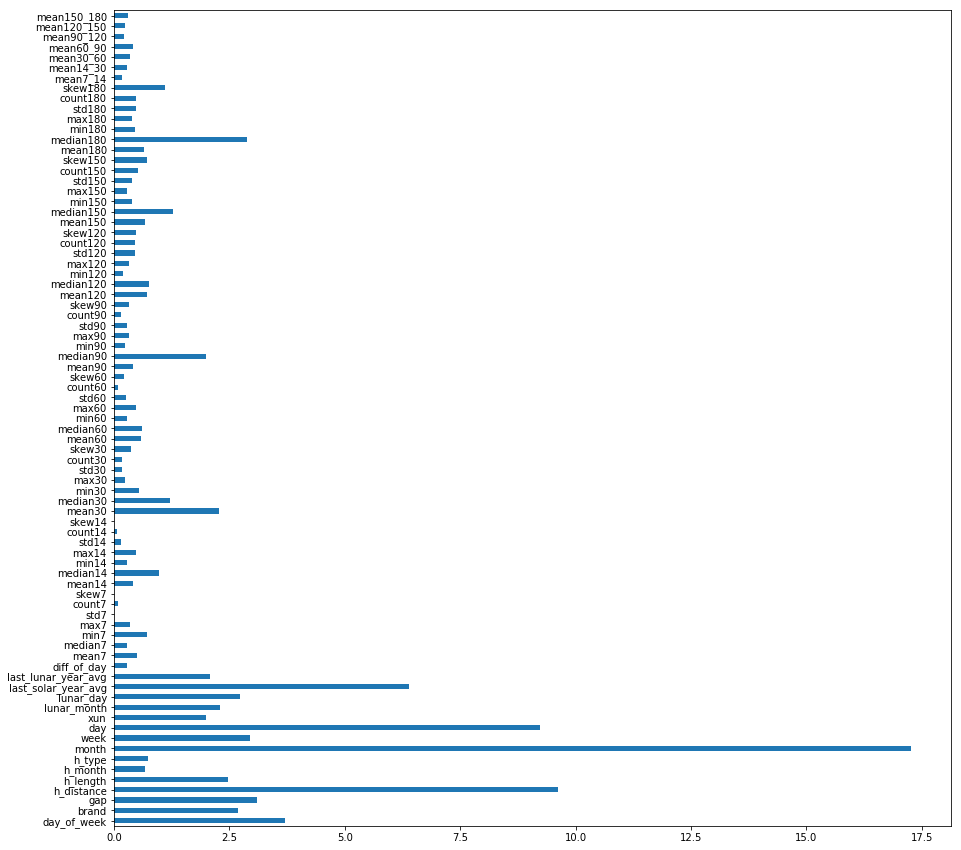

In [52]:
pd.Series(model1.feature_importances_, index = train_X.columns).plot.barh(figsize=(15,15))

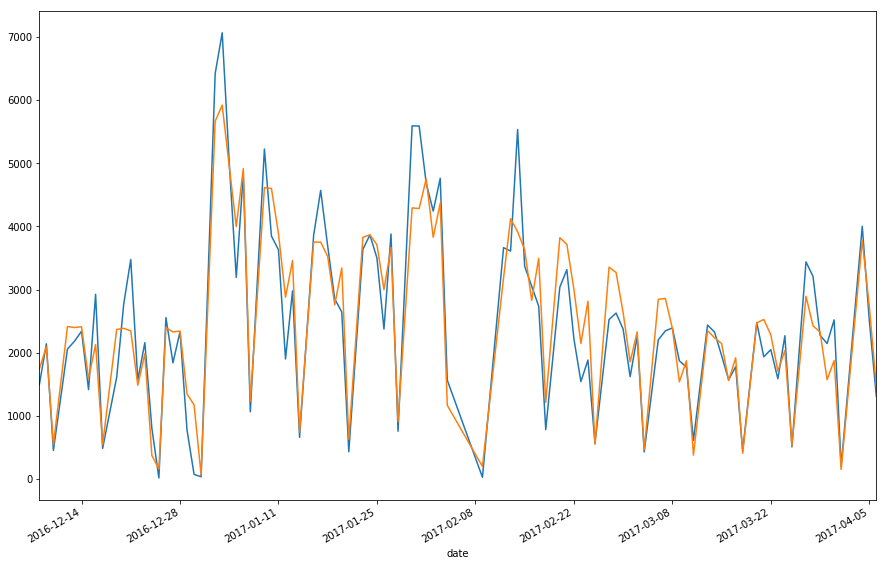

In [51]:
pd.Series(testy_sum).plot(figsize=(15,10))
pd.Series(predict_sum).plot(figsize=(15,10))

## TEST

In [56]:
df_test = pd.read_table('test_A_20171225.txt',encoding='gbk',sep='\t')

In [57]:
df_test = df_test.set_index('date')
df_test.drop(df_test.index[0], inplace=True)
df_test.head(5)

,day_of_week
date,
1033,5
1034,6
1035,1
1036,2
1037,3


In [58]:
train_index = df_train.index
test_index = df_test.index

NameError: name 'df_train' is not defined

In [239]:
whole_df = pd.DataFrame()
for b in range(1,6):
    
    train_X_b = train_X[train_X['brand']==b]
    test_X_b = test_X[test_X['brand']==b]
    train_Y_b = train_Y[train_X['brand']==b]

    predict = 0
    bagging_num = 1
    for i in range(bagging_num):
        model1 = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=2000, max_depth=9, max_features=0.8,
                                               min_samples_split = 4, random_state = i*3)
        model1.fit(train_X_b.fillna(-1), train_Y_b)
        predict +=  0.4*model1.predict(test_X_b.fillna(-1))

        model1 = LGBMRegressor(learning_rate=0.011, n_estimators=1600, subsample=0.7, num_leaves=55+i*5, 
                               colsample_bytree=0.6, random_seed = i*3)
        model1.fit(train_X_b.fillna(-1), train_Y_b)
        predict +=  model1.predict(test_X_b.fillna(-1))

        model1 = CatBoostRegressor(iterations=1500, learning_rate=0.04, depth=8, l2_leaf_reg=2, loss_function='RMSE', 
                               eval_metric='RMSE', logging_level='Silent', random_seed=i*5)
        model1.fit(train_X_b.fillna(-1), train_Y_b, cat_features=[6,7,8])
        predict += 1.5*model1.predict(test_X_b.fillna(-1))

    predict = predict/bagging_num/2.9
    
    predict_df = pd.DataFrame()
    predict_df['date'] = df.loc[test_X_b.index,'virtual_date']
    predict_df['y'] = predict
    whole_df = pd.concat([whole_df, predict_df])


In [240]:
predict_sum = whole_df.groupby(['date']).y.agg('sum')

In [241]:
error = predict_sum.values-testy_sum.values
metric= np.mean(np.square(error))
print(metric)

401963.21609


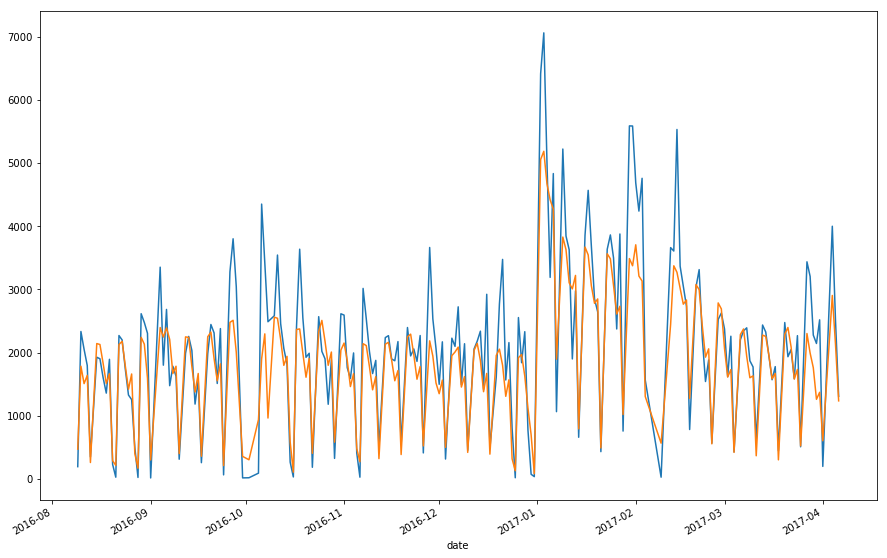

In [242]:
pd.Series(testy_sum).plot(figsize=(15,10))
pd.Series(predict_sum).plot(figsize=(15,10))

In [214]:
train_X_b.head()

,day_of_week_x,brand,day_of_week_y,gap,h_distance,h_length,h_month,h_type,month,week,day,xun,lunar_month,lunar_day,last_solar_year_avg,last_lunar_year_avg
1,3,5,3,1,40,6,2,1.0,1,1,1,0,12,1,317.5,319.346154
8,5,5,5,1,38,6,2,1.0,1,1,3,0,12,3,317.5,319.346154
13,6,5,6,1,37,6,2,1.0,1,1,4,0,12,4,317.5,319.346154
18,7,5,7,1,36,6,2,1.0,1,1,5,0,12,5,317.5,319.346154
23,1,5,1,1,35,6,2,1.0,1,2,6,0,12,6,317.5,319.346154
